University of Helsinki, Master's Programme in Data Science  
DATA20019 Trustworthy Machine Learning, Autumn 2019  
Antti Honkela and Razane Tajeddine  

# Project 2: Real-life privacy-preserving machine learning

Deadline for returning the solutions: 24 November 23:55.

## General instructions (IMPORTANT!)

1. This is an individual project. You can discuss the solutions with other students, but everyone needs to write their own code and answers.
2. Please return your solutions as a notebook. When returning your solutions, please leave all output in the notebook.
3. When returning your solutions, please make sure the notebook can be run cleanly using "Cell" / "Run All".
4. Please make sure there are no dependencies between solutions to different problems.
5. Please make sure that your notebook will not depend on any local files.
6. Please make sure that the solutions for each problem in your notebook will produce the same results when run multiple times, i.e. remember to seed any random number generators you use (`numpy.random.seed()`!).


## Task 1: Differentially private logistic regression with DP-SGD and synthetic data

TensorFlow Privacy (https://github.com/tensorflow/privacy) library provides implementations of many differentially private optimisation algorithms for deep learning and other models. In order to perform these exercises, you will need to install TensorFlow Privacy and its dependencies according to instructions given on the website.

In order to study TensorFlow Privacy, we will use logistic regression on a small synthetic data set. This will be faster to run than larger neural network models. A simple example implementation of the model is available at https://github.com/ahonkela/privacy/blob/master/tutorials/toy_lr_tutorial.py
The code has been adapted from tutorials provided with TensorFlow privacy.

The definition of the logistic regression model binary classification is itself very straightforward in TensorFlow, simply using a single fully connected linear layer with cross entropy loss:
```{python}
  # Define logistic regression model using tf.keras.layers.
  logits = tf.keras.layers.Dense(2).apply(features['x'])

  # Calculate loss as a vector (to support microbatches in DP-SGD).
  vector_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(
      labels=labels, logits=logits)
```

The rest of the example provides supporting architecture. Key parameters of the algorithm are defined as `flags` at the beginning of the file. These include:
```{python}
flags.DEFINE_float('learning_rate', .05, 'Learning rate for training')
flags.DEFINE_float('noise_multiplier', 2.0,
                   'Ratio of the standard deviation to the clipping norm')
flags.DEFINE_float('l2_norm_clip', 1.0, 'Clipping norm')
flags.DEFINE_integer('batch_size', 64, 'Batch size')
flags.DEFINE_integer('epochs', 2, 'Number of epochs')
```

`learning_rate` is the initial learning rate for the Adam optimiser. Larger value means faster learning but can cause instability.  
`noise_multiplier` controls the amount of noise added in DP-SGD: higher value means more noise. The value is defined relative to the gradient clipping norm.  
`l2_norm_clip` is the maximum norm at which per-example gradients are clipped. Smaller values mean less noise with the same level of privacy, but too small values can bias the results and make learning impossible.  
`batch_size` is the minibatch size which impacts privacy via amplification from subsampling. Smaller batch sizes increase privacy for equal number of epochs, but too small batches can make the learning unstable.  
`epochs` controls the length of training as a number of passes over the entire data.

Test how these parameters (clipping threshold, batch size, noise multiplier and learning rate) affect the accuracy or the classifier and the privacy. Plot all your results to a privacy ($\epsilon$) vs. accuracy plot to trace the optimal accuracy achievable under a specific level of privacy.

You can limit the number of experiments to keep the runtimes reasonable: it is not necessary to try every combination of parameters but you can focus on testing the effect of one variable at a time. TensorFlow can use GPUs which can speed up learning significantly.

Note: testing several hyperparameters and choosing the best has an impact on the privacy guarantees. There are methods for dealing with this (e.g. https://arxiv.org/abs/1811.07971) but the field is still under active development.

In [1]:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from absl import app
from absl import flags

import numpy as np
import numpy.random as npr
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow_privacy.privacy.analysis import privacy_ledger
from tensorflow_privacy.privacy.analysis.rdp_accountant import compute_rdp_from_ledger
from tensorflow_privacy.privacy.analysis.rdp_accountant import get_privacy_spent
from tensorflow_privacy.privacy.optimizers import dp_optimizer

AdamOptimizer = tf.compat.v1.train.AdamOptimizer

# FLAGS = flags.FLAGS

# flags.DEFINE_boolean(
#         'dpsgd', True, 'If True, train with DP-SGD. If False, '
#         'train with vanilla SGD.')
# flags.DEFINE_float('learning_rate', .05, 'Learning rate for training')
# flags.DEFINE_float('noise_multiplier', 2.0,
#                                      'Ratio of the standard deviation to the clipping norm')
# flags.DEFINE_float('l2_norm_clip', 1.0, 'Clipping norm')
# flags.DEFINE_integer('batch_size', 64, 'Batch size')
# flags.DEFINE_integer('epochs', 2, 'Number of epochs')
# flags.DEFINE_integer('training_data_size', 2000, 'Training data size')
# flags.DEFINE_integer('test_data_size', 2000, 'Test data size')
# flags.DEFINE_integer('input_dimension', 5, 'Input dimension')
# flags.DEFINE_string('model_dir', None, 'Model directory')



In [ ]:
epsilons = []
accuracies = []

class EpsilonPrintingTrainingHook(tf.estimator.SessionRunHook):
    """Training hook to print current value of epsilon after an epoch."""

    def __init__(self, ledger):
        """Initalizes the EpsilonPrintingTrainingHook.
        Args:
            ledger: The privacy ledger.
        """
        self._samples, self._queries = ledger.get_unformatted_ledger()

    def end(self, session):
        orders = [1 + x / 10.0 for x in range(1, 100)] + list(range(12, 64))
        samples = session.run(self._samples)
        queries = session.run(self._queries)
        formatted_ledger = privacy_ledger.format_ledger(samples, queries)
        rdp = compute_rdp_from_ledger(formatted_ledger, orders)
        eps = get_privacy_spent(orders, rdp, target_delta=1e-5)[0]
        epsilons.append(eps)
        #print('For delta=1e-5, the current epsilon is: %.2f' % eps)


def lr_model_fn(features, labels, mode):
    """Model function for a LR."""

    # Define logistic regression model using tf.keras.layers.
    logits = tf.keras.layers.Dense(2).apply(features['x'])

    # Calculate loss as a vector (to support microbatches in DP-SGD).
    vector_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(
            labels=labels, logits=logits)
    # Define mean of loss across minibatch (for reporting through tf.Estimator).
    scalar_loss = tf.reduce_mean(input_tensor=vector_loss)

    # Configure the training op (for TRAIN mode).
    if mode == tf.estimator.ModeKeys.TRAIN:

        if dpsgd:
            ledger = privacy_ledger.PrivacyLedger(
                    population_size=training_data_size,
                    selection_probability=(batch_size / training_data_size))

            # Use DP version of AdamOptimizer. Other optimizers are
            # available in dp_optimizer. Most optimizers inheriting from
            # tf.train.Optimizer should be wrappable in differentially private
            # counterparts by calling dp_optimizer.optimizer_from_args().
            # Setting num_microbatches to None is necessary for DP and
            # per-example gradients
            optimizer = dp_optimizer.DPAdamGaussianOptimizer(
                    l2_norm_clip=l2_norm_clip,
                    noise_multiplier=noise_multiplier,
                    num_microbatches=None,
                    ledger=ledger,
                    learning_rate=learning_rate)
            training_hooks = [
                    EpsilonPrintingTrainingHook(ledger)
            ]
            opt_loss = vector_loss
        else:
            optimizer = AdamOptimizer(learning_rate=learning_rate)
            training_hooks = []
            opt_loss = scalar_loss
        global_step = tf.compat.v1.train.get_global_step()
        train_op = optimizer.minimize(loss=opt_loss, global_step=global_step)
        # In the following, we pass the mean of the loss (scalar_loss) rather than
        # the vector_loss because tf.estimator requires a scalar loss. This is only
        # used for evaluation and debugging by tf.estimator. The actual loss being
        # minimized is opt_loss defined above and passed to optimizer.minimize().
        return tf.estimator.EstimatorSpec(mode=mode,
                                                                            loss=scalar_loss,
                                                                            train_op=train_op,
                                                                            training_hooks=training_hooks)

    # Add evaluation metrics (for EVAL mode).
    elif mode == tf.estimator.ModeKeys.EVAL:
        eval_metric_ops = {
                'accuracy':
                        tf.compat.v1.metrics.accuracy(
                                labels=labels,
                                predictions=tf.argmax(input=logits, axis=1))
        }

        return tf.estimator.EstimatorSpec(mode=mode,
                                                                            loss=scalar_loss,
                                                                            eval_metric_ops=eval_metric_ops)

def generate_data():
    npr.seed(4242)
    N_train = training_data_size
    N_test = test_data_size
    N = N_train + N_test
    X0 = npr.randn(N, input_dimension)
    temp = X0 @ npr.randn(input_dimension, 1) + npr.randn(N, 1)
    Y0 = np.round(1/(1+np.exp(-temp)))

    train_X = X0[0:N_train, :]
    test_X = X0[N_train:N, :]
    train_Y = Y0[0:N_train, 0]
    test_Y = Y0[N_train:N, 0]
    train_X = np.array(train_X, dtype=np.float32)
    test_X = np.array(test_X, dtype=np.float32)
    train_Y = np.array(train_Y, dtype=np.int32)
    test_Y = np.array(test_Y, dtype=np.int32)
    return train_X, train_Y, test_X, test_Y
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


vals = {
    'clip': [1, 5, 25, 50],
    'batch': [64, 16, 256, 1],
    'noise': [.5, 1, 2, 4, 8],
    'lr': [.5, .05, .005, .0005]
}

hist_eps = {}
hist_acc = {}
params = ['clip', 'batch', 'noise', 'lr']
for param in params:
    dpsgd = True
    learning_rate = .05
    noise_multiplier = 2.0
    l2_norm_clip = 1.0
    batch_size = 64
    epochs = 2
    training_data_size = 2000
    test_data_size = 2000
    input_dimension = 5
    model_dir = None
    for val in vals[param]:
        if param == 'clip':
            l2_norm_clip = val
        if param == 'batch':
            batch_size = val
        if param == 'noise':
            noise_multiplier = val
        if param == 'lr':
            learning_rate = val
        
        # Load training and test data.
        train_data, train_labels, test_data, test_labels = generate_data()

        # Instantiate the tf.Estimator.
        lr_classifier = tf.estimator.Estimator(model_fn=lr_model_fn,model_dir=model_dir)

        # Create tf.Estimator input functions for the training and test data.
        train_input_fn = tf.compat.v1.estimator.inputs.numpy_input_fn(
                x={'x': train_data},
                y=train_labels,
                batch_size=batch_size,
                num_epochs=epochs,
                shuffle=True)
        eval_input_fn = tf.compat.v1.estimator.inputs.numpy_input_fn(
                x={'x': test_data},
                y=test_labels,
                num_epochs=1,
                shuffle=False)
        history = ''
        # Training loop.
        steps_per_epoch = training_data_size // batch_size / 10
        for epoch in range(1, 10*epochs + 1):
            # Train the model for one epoch.
            history = lr_classifier.train(input_fn=train_input_fn, steps=steps_per_epoch)

            # Evaluate the model and print results
            eval_results = lr_classifier.evaluate(input_fn=eval_input_fn)
            test_accuracy = eval_results['accuracy']
            print('Test accuracy after %.1f epochs is: %.3f' % (epoch/10, test_accuracy))
            accuracies.append(test_accuracy)
        hist_eps[f'{param}-{val}'] = epsilons
        hist_acc[f'{param}-{val}'] = accuracies
        assert(len(epsilons) == len(accuracies))
        epsilons = []
        accuracies = []

Test accuracy after 0.1 epochs is: 0.637
Test accuracy after 0.2 epochs is: 0.725
Test accuracy after 0.3 epochs is: 0.762
Test accuracy after 0.4 epochs is: 0.795
Test accuracy after 0.5 epochs is: 0.812
Test accuracy after 0.6 epochs is: 0.820
Test accuracy after 0.7 epochs is: 0.827
Test accuracy after 0.8 epochs is: 0.836
Test accuracy after 0.9 epochs is: 0.839
Test accuracy after 1.0 epochs is: 0.841
Test accuracy after 1.1 epochs is: 0.842
Test accuracy after 1.2 epochs is: 0.836
Test accuracy after 1.3 epochs is: 0.838
Test accuracy after 1.4 epochs is: 0.836
Test accuracy after 1.5 epochs is: 0.837
Test accuracy after 1.6 epochs is: 0.836
Test accuracy after 1.7 epochs is: 0.835
Test accuracy after 1.8 epochs is: 0.836
Test accuracy after 1.9 epochs is: 0.836
Test accuracy after 2.0 epochs is: 0.839
Test accuracy after 0.1 epochs is: 0.658
Test accuracy after 0.2 epochs is: 0.717
Test accuracy after 0.3 epochs is: 0.776
Test accuracy after 0.4 epochs is: 0.817
Test accuracy af

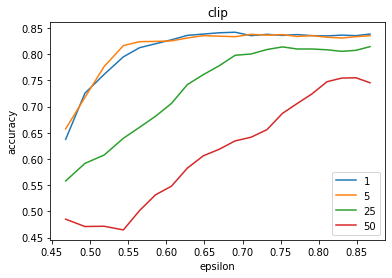

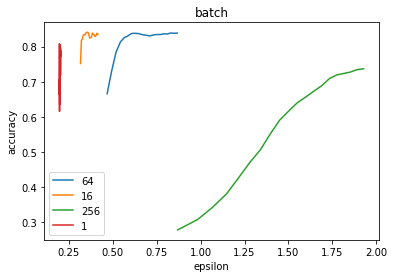

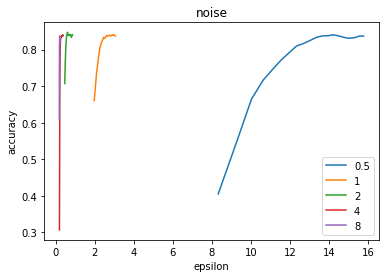

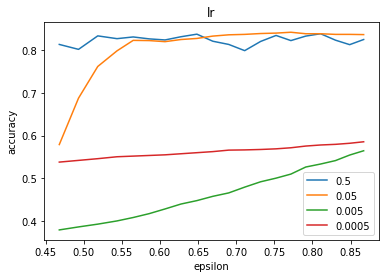

In [ ]:

for param in params:
    for val in vals[param]:
        try:
            epsilons = hist_eps[f'{param}-{val}']
            accuracies = hist_acc[f'{param}-{val}']
            plt.plot(epsilons, accuracies)
            
        except:
            pass

    plt.title(param)
    plt.legend(vals[param])
    plt.xlabel('epsilon')
    plt.ylabel('accuracy')
    plt.show()


## Task 2: DP logistic regression on realistic data

Using the above code as a basis, build a DP logistic regression classifier for the UCI Adult data set (https://archive.ics.uci.edu/ml/datasets/Adult). (The data set is a standard benchmark data set that is available in various packages - feel free to use one of those.)

How accurate classifier can you build to predict if an individual has an income of at most 50k, using DP with $\epsilon=1, \delta = 10^{-5}$? Report your accuracy on the separate test set not used in learning.

Hint: the data set includes many categorical variables. In order to use these, you will need to use a one-hot encoding with $n-1$ variables used to denote $n$ values so that $k$th value is represented by value 1 in $k-1$st variable and zeros otherwise.

In [2]:


import pandas as pd
import numpy as np
from sklearn import preprocessing
columns=['age', 'workclass',  'fnlwgt', 'education', 'education-num', 'marital-status',
       'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
       'hours-per-week', 'native-country', 'salary']
train = pd.read_csv('adult.data', header=None, names=columns)
test = pd.read_csv('adult.test', header=None, names=columns)


def transform(data):
    y = sorted(list(set([x.strip() for x in data['salary']])))
    data['Y'] = data['salary'].map(lambda x: y.index(x.strip()))
    
    data['private_employment'] = data['workclass'].map(lambda x: 1 if str(x).strip() == 'Private' else 0)
    data['public_employment'] = data['workclass'].map(lambda x: 1 if str(x).strip() in ['Local-gov', 'Federal-gov', 'State-gov'] else 0)
    data['unknown_employment'] = data['workclass'].map(lambda x: 1 if str(x).strip() in ['?'] else 0)
    data['un_employment'] = data['workclass'].map(lambda x: 1 if str(x).strip() in ['Never-worked', 'Without-pay'] else 0)
    
    data['assoc_ed'] = data['education'].map(lambda x: 1 if str(x).strip() in ['Assoc-voc', 'Assoc-acdm'] else 0)
    data['hs_ed'] = data['education'].map(lambda x: 1 if str(x).strip() in ['HS-grad'] else 0)
    data['assoc_ed'] = data['education'].map(lambda x: 1 if str(x).strip() in ['Assoc-voc', 'Assoc-acdm'] else 0)
    data['lower_ed'] = data['education'].map(lambda x: 1 if str(x).strip() in ['11th', '10th', '7th-8th', '9th', '12th', '5th-6th', '1st-4th', 'Preschool'] else 0)
    data['some_college_ed'] = data['education'].map(lambda x: 1 if str(x).strip() in ['Some-college'] else 0)
    data['bach_ed'] = data['education'].map(lambda x: 1 if str(x).strip() in ['Bachelors'] else 0)
    data['masters_ed'] = data['education'].map(lambda x: 1 if str(x).strip() in ['Masters'] else 0)
    data['prof_ed'] = data['education'].map(lambda x: 1 if str(x).strip() in ['Prof-school'] else 0)
    
    data['married'] = data['marital-status'].map(lambda x: 1 if str(x).strip() in ['Married-civ-spouse', 'Married-spouse-absent'] else 0 )
    data['never_married'] = data['marital-status'].map(lambda x: 1 if str(x).strip() in ['Never-married'] else 0 )
    data['separated'] = data['marital-status'].map(lambda x: 1 if str(x).strip() in ['Separated', 'Divorced', 'Widowed'] else 0 )
    
    data['specialty'] = data['occupation'].map(lambda x: 1 if str(x).strip() in ['Prof-specialty'] else 0)
    data['craft'] = data['occupation'].map(lambda x: 1 if str(x).strip() in ['Craft-repair'] else 0)
    data['executive'] = data['occupation'].map(lambda x: 1 if str(x).strip() in ['Exec-managerial'] else 0)
    data['cleric'] = data['occupation'].map(lambda x: 1 if str(x).strip() in ['Adm-clerical'] else 0)
    data['sales'] = data['occupation'].map(lambda x: 1 if str(x).strip() in ['Sales'] else 0)
    data['other'] = data['occupation'].map(lambda x: 1 if str(x).strip() in ['Other-service'] else 0)
    data['machine'] = data['occupation'].map(lambda x: 1 if str(x).strip() in ['Machine-op-inspct'] else 0)
    data['prof_unknown'] = data['occupation'].map(lambda x: 1 if str(x).strip() in ['?'] else 0)
    data['transport'] = data['occupation'].map(lambda x: 1 if str(x).strip() in ['Transport-moving'] else 0)
    data['cleaners'] = data['occupation'].map(lambda x: 1 if str(x).strip() in ['Handlers-cleaners'] else 0)
    data['farming'] = data['occupation'].map(lambda x: 1 if str(x).strip() in ['Farming-fishing'] else 0)
    data['tech_supp'] = data['occupation'].map(lambda x: 1 if str(x).strip() in ['Tech-support'] else 0)
    data['prot_serv'] = data['occupation'].map(lambda x: 1 if str(x).strip() in ['Protective-serv'] else 0)
    data['priv_serv'] = data['occupation'].map(lambda x: 1 if str(x).strip() in ['Priv-house-serv'] else 0)

    data['not_in_family'] = data['relationship'].map(lambda x: 1 if str(x).strip() in ['Not-in-family'] else 0)
    data['own_child'] = data['relationship'].map(lambda x: 1 if str(x).strip() in ['Own-child'] else 0)
    data['other_relative'] = data['relationship'].map(lambda x: 1 if str(x).strip() in ['Other-relative'] else 0)

    data['white'] = data['race'].map(lambda x: 1 if str(x).strip() in ['White'] else 0)
    data['black'] = data['race'].map(lambda x: 1 if str(x).strip() in ['Black'] else 0)
    data['asian'] = data['race'].map(lambda x: 1 if str(x).strip() in ['Asian-Pac-Islander'] else 0)
    data['am_ind_esk'] = data['race'].map(lambda x: 1 if str(x).strip() in ['Amer-Indian-Eskimo'] else 0)
    data['race_other'] = data['race'].map(lambda x: 1 if str(x).strip() in ['Other'] else 0)
    
    data['gender'] = data['sex'].map(lambda x: 1 if str(x).strip() in ['Male'] else 0)
    data['country_unk'] = data['native-country'].map(lambda x: 1 if str(x).strip() in ['?'] else 0)
    data['country_us'] = data['native-country'].map(lambda x: 1 if str(x).strip() in ['United-States'] else 0)
    data['country_mex'] = data['native-country'].map(lambda x: 1 if str(x).strip() in ['Mexico'] else 0)
    data['country_asia'] = data['native-country'].map(lambda x: 1 if str(x).strip() in ['Philippines', 'India', 'China', 'Vietnam', 'Japan', 'Taiwan', 'Iran', 'Hong', 'Thailand', 'Laos'] else 0)
    data['country_sa'] = data['native-country'].map(lambda x: 1 if str(x).strip() in ['Puerto-Rico', 'El-Salvador', 'Jamaica', 'Dominican-Republic', 'Guatemala', 'Columbia', 'Haiti', 'Nicaragua', 'Peru','Ecuador', 'Cambodia', 'Trinidad&Tobago'] else 0)
    data['country_europe'] = data['native-country'].map(lambda x: 1 if str(x).strip() in ['Germany', 'England', 'Italy', 'Poland', 'Portugal', 'France', 'Greece', 'Ireland', 'Yugoslavia', 'Hungary', 'Scotland', 'Holland-Netherlands'] else 0)
  

    mm_scaler = preprocessing.MinMaxScaler()
    data.drop('sex', 1, inplace=True)
    data.drop('race', 1, inplace=True)
    data.drop('native-country', 1, inplace=True)
    data.drop('education', 1, inplace=True)
    data.drop('workclass', 1, inplace=True)
    data.drop('salary', 1, inplace=True)
    data.drop('marital-status', 1, inplace=True)
    data.drop('relationship', 1, inplace=True)
    data.drop('occupation', 1, inplace=True)
    y = data['Y'].values
    data.drop('Y', 1, inplace=True)
    data = mm_scaler.fit_transform(data)
    
    return data.astype(np.float32), y.astype(np.int64)
    
    
    
train_x, train_y = transform(train)
test_x, test_y = transform(test)


In [3]:

with tf.device('/GPU:0'):
  tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
  class EpsilonPrintingTrainingHook(tf.estimator.SessionRunHook):
      """Training hook to print current value of epsilon after an epoch."""

      def __init__(self, ledger):
          """Initalizes the EpsilonPrintingTrainingHook.
          Args:
              ledger: The privacy ledger.
          """
          self._samples, self._queries = ledger.get_unformatted_ledger()

      def end(self, session):
          orders = [1 + x / 10.0 for x in range(1, 100)] + list(range(12, 64))
          samples = session.run(self._samples)
          queries = session.run(self._queries)
          formatted_ledger = privacy_ledger.format_ledger(samples, queries)
          rdp = compute_rdp_from_ledger(formatted_ledger, orders)
          eps = get_privacy_spent(orders, rdp, target_delta=1e-5)[0]
          epsilons.append(eps)
          print('For delta=1e-5, the current epsilon is: %.2f' % eps)

  def lr_model_fn(features, labels, mode):
      """Model function for a LR."""

      # Define logistic regression model using tf.keras.layers.
      logits = tf.keras.layers.Dense(2).apply(features['x'])

      # Calculate loss as a vector (to support microbatches in DP-SGD).
      vector_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(
              labels=labels, logits=logits)
      # Define mean of loss across minibatch (for reporting through tf.Estimator).
      scalar_loss = tf.reduce_mean(input_tensor=vector_loss)

      # Configure the training op (for TRAIN mode).
      if mode == tf.estimator.ModeKeys.TRAIN:

          if dpsgd:
              ledger = privacy_ledger.PrivacyLedger(
                      population_size=training_data_size,
                      selection_probability=(batch_size / training_data_size))

              # Use DP version of AdamOptimizer. Other optimizers are
              # available in dp_optimizer. Most optimizers inheriting from
              # tf.train.Optimizer should be wrappable in differentially private
              # counterparts by calling dp_optimizer.optimizer_from_args().
              # Setting num_microbatches to None is necessary for DP and
              # per-example gradients
              optimizer = dp_optimizer.DPAdamGaussianOptimizer(
                      l2_norm_clip=l2_norm_clip,
                      noise_multiplier=noise_multiplier,
                      num_microbatches=None,
                      ledger=ledger,
                      learning_rate=learning_rate)
              training_hooks = [
                      EpsilonPrintingTrainingHook(ledger)
              ]
              opt_loss = vector_loss
          else:
              optimizer = AdamOptimizer(learning_rate=learning_rate)
              training_hooks = []
              opt_loss = scalar_loss
          global_step = tf.compat.v1.train.get_global_step()
          train_op = optimizer.minimize(loss=opt_loss, global_step=global_step)
          # In the following, we pass the mean of the loss (scalar_loss) rather than
          # the vector_loss because tf.estimator requires a scalar loss. This is only
          # used for evaluation and debugging by tf.estimator. The actual loss being
          # minimized is opt_loss defined above and passed to optimizer.minimize().
          return tf.estimator.EstimatorSpec(mode=mode,
                                                                              loss=scalar_loss,
                                                                              train_op=train_op,
                                                                              training_hooks=training_hooks)

      # Add evaluation metrics (for EVAL mode).
      elif mode == tf.estimator.ModeKeys.EVAL:
          eval_metric_ops = {
                  'accuracy':
                          tf.compat.v1.metrics.accuracy(
                                  labels=labels,
                                  predictions=tf.argmax(input=logits, axis=1))
          }
          return tf.estimator.EstimatorSpec(mode=mode,
                                                                              loss=scalar_loss,
                                                                              eval_metric_ops=eval_metric_ops)

  epsilons = [0]
  accuracies = []
  dpsgd = True
  learning_rate = .05
  noise_multiplier = 2.0
  l2_norm_clip = 1.0
  batch_size = 64
  training_data_size=len(train_x)
  test_data_size =len(test_x)
  epochs = 2
  model_dir = None

  # Load training and test data.
  train_data, train_labels, test_data, test_labels = train_x, train_y, test_x, test_y


  # Instantiate the tf.Estimator.
  lr_classifier = tf.estimator.Estimator(model_fn=lr_model_fn,model_dir=model_dir)

  # Create tf.Estimator input functions for the training and test data.
  train_input_fn = tf.compat.v1.estimator.inputs.numpy_input_fn(
          x={'x': train_data},
          y=train_labels,
          batch_size=batch_size,
          num_epochs=epochs,
          shuffle=True)
  eval_input_fn = tf.compat.v1.estimator.inputs.numpy_input_fn(
                x={'x': test_data},
                y=test_labels,
                num_epochs=1,
                shuffle=True)

  # Training loop.
  steps_per_epoch = training_data_size // batch_size / 10
  epoch = 0
  while epsilons[-1] < 0.99 and epoch < 40:
      epoch += 1
      # Train the model for one epoch.
      lr_classifier.train(input_fn=train_input_fn, steps=steps_per_epoch)

      # Evaluate the model and print results
      eval_results = lr_classifier.evaluate(input_fn=eval_input_fn)
      test_accuracy = eval_results['accuracy']
      print('Test accuracy is: %.3f, epsilon is %.3f' % (test_accuracy, epsilons[-1]))
      accuracies.append(test_accuracy)

For delta=1e-5, the current epsilon is: 0.24
Test accuracy is: 0.818, epsilon is 0.241
For delta=1e-5, the current epsilon is: 0.24
Test accuracy is: 0.825, epsilon is 0.243


KeyboardInterrupt: 

In [ ]:
plt.plot(epsilons[1:], accuracies)
plt.title('Plot of accuracy and epsilon')
plt.show()


In [5]:
len(train_x)

32561

## Task 3: Your own problem in privacy-preserving machine learning

State and solve your own problem related to privacy-preserving machine learning.

You can use code available online, as long as you cite the source.

You can for example try reproducing the results of some interesting paper using their data or your own data, try out some of the privacy attacks, or simply try the above examples using more complex models and/or on different data sets.

If your problem is based on some previous problem, it should extend it in a non-trivial manner (not just running exact same code with new parameters or data).

The evaluation of the project will take the difficulty of your chosen problem into account.

This task is worth as much as two regular problems.

I tried to extract faces from a model like in this paper https://www.cs.cmu.edu/~mfredrik/papers/fjr2015ccs.pdf. I am not sure if I exactly did what was described there, but anyways I used the same 400 image facial dataset and got somewhat similar results as were shown in the paper. I tried to add some noise to the image at each step to improve constrast, without doing it the algorithm seemed to converge to mostly black images that were hard to make out. Also adding a sharpening filter made the features more easily distinctive. I think most of the faces could be recognized from the blurry versions in the end. There is a bit of variance in the end result depending on how much the model is trained especially since the dataset is very small.

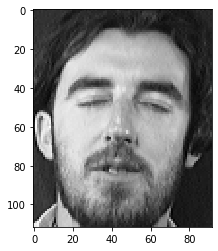

In [ ]:
import torch
import os
from PIL import Image
import numpy as np
import torchvision.transforms as transforms

classes = os.listdir('./faces/train')
c_to_i = lambda x: classes.index(x)
i_to_c = lambda x: classes[x]

transformer = transforms.Compose([
    transforms.ToTensor(),
])

def show_img(im):
    plt.imshow(im.reshape(112, 92) / 2 + .5, cmap='gray')
    plt.show()
    
def one_hot(x):
    vec = [0] *len(classes)
    vec[x] = 1
    return vec
    
train =test= 0
train_x, train_y = ([0]) * 360, ([0]) * 360
test_x, test_y = ([0]) * 40, ([0]) * 40
asd = []

for c in os.listdir('./faces/train/'):
    for faces in os.listdir('./faces/train/'+c):
        img = np.array(Image.open('./faces/train/'+c+'/'+faces).convert('L'))
        train_x[train] = (img).flatten()
        train_y[train] = (c_to_i(c))
        train += 1

for c in os.listdir('./faces/test/'):
    for faces in os.listdir('./faces/test/'+c):
        img = np.array(Image.open('./faces/test/'+c+'/'+faces).convert('L'))
        test_x[test] = img.flatten()
        test_y[test] = (c_to_i(c))
        test += 1

train_x = np.stack([x.flatten() for x in train_x])
test_x = np.stack([x.flatten() for x in test_x])
test_y = np.array(test_y,  dtype=np.int64)
train_y = np.array(train_y, dtype=np.int64)

show_img(train_x[0])

In [ ]:
class FaceModel(torch.nn.Module):
    def __init__(self, D_in, D_out):
        super(FaceModel, self).__init__()
        
        self.linear1 = torch.nn.Linear(D_in, D_out)
        
    def forward(self,x):
        return self.linear1(x)

model = FaceModel(len(train_x[0]), len(classes))
    
steps = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=3e-1)

for i in range(steps):
    optimizer.zero_grad()
    y_hat = model(torch.Tensor(train_x))
    loss = criterion(y_hat, torch.LongTensor(train_y))
    loss.backward()
    optimizer.step()


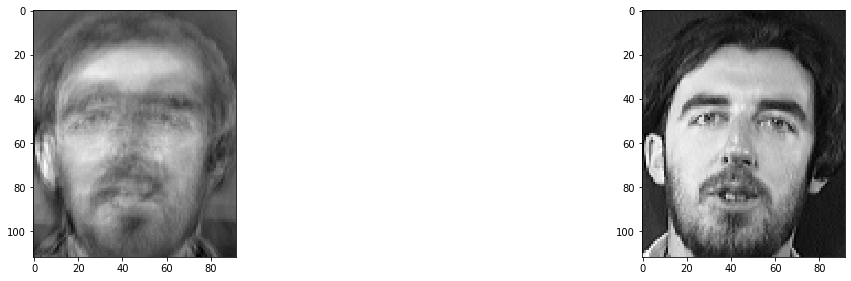

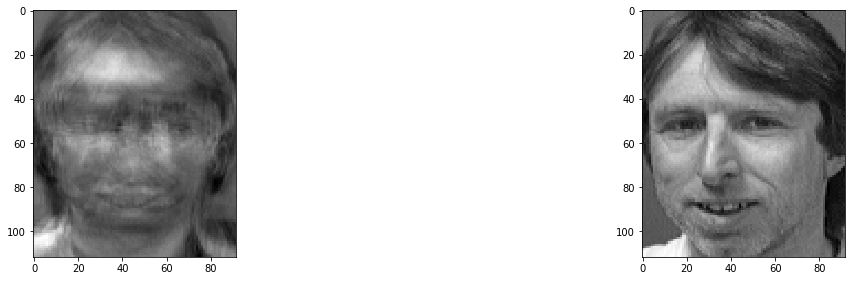

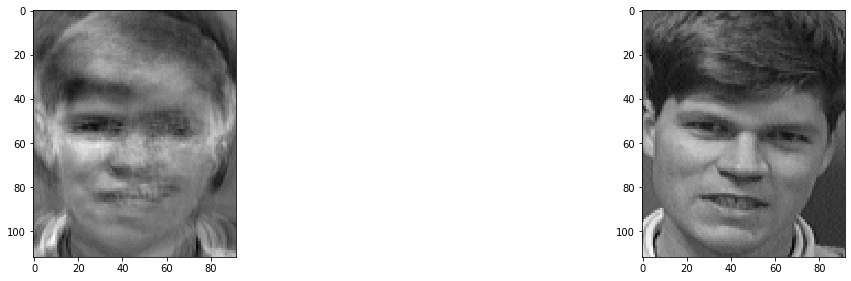

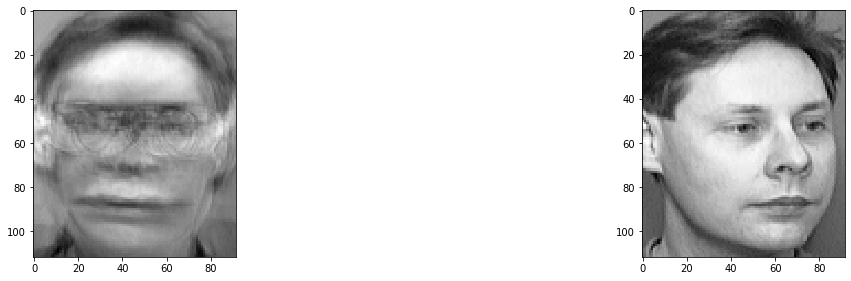

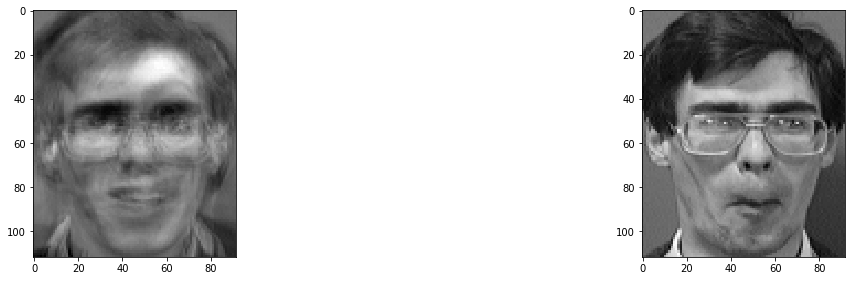

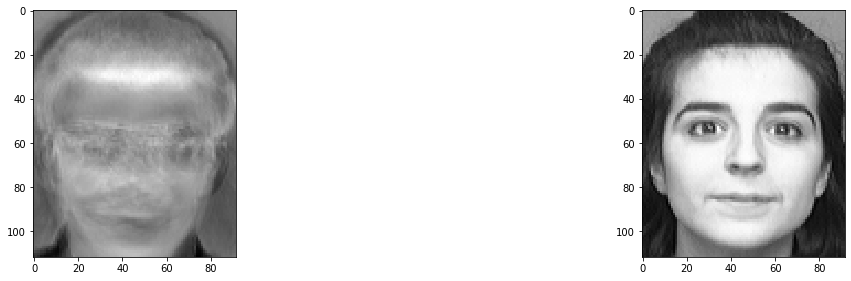

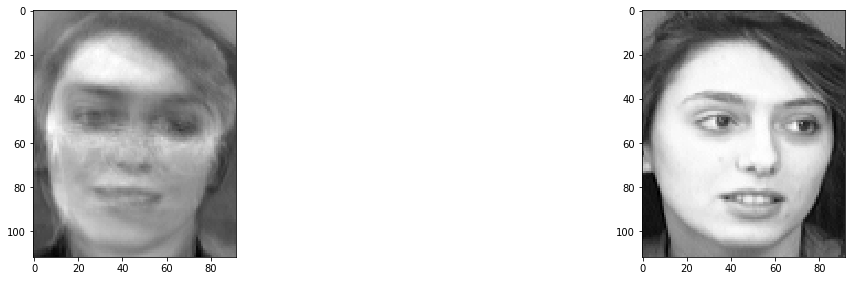

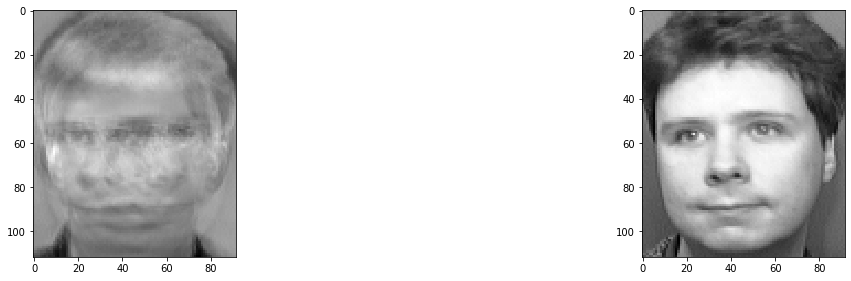

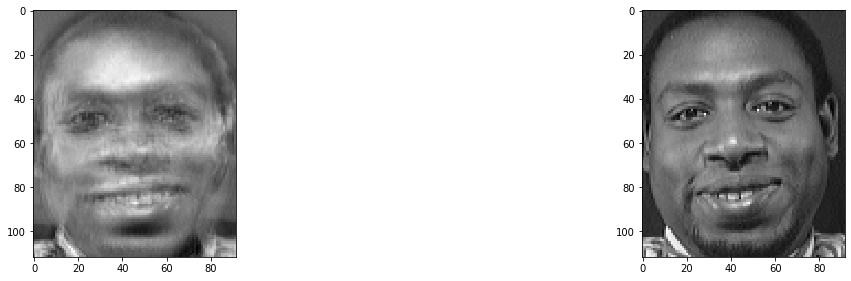

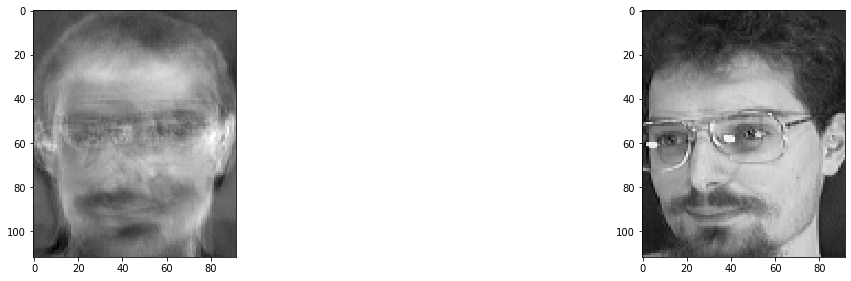

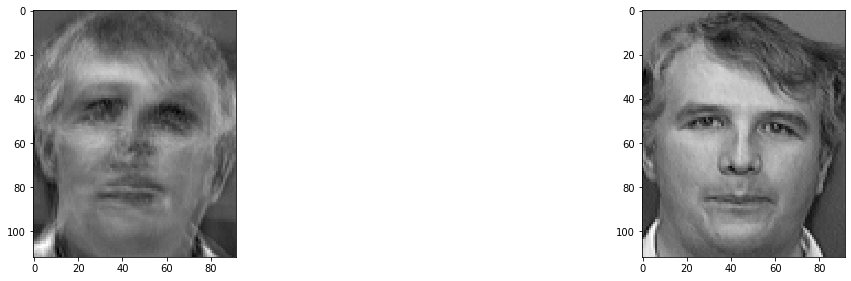

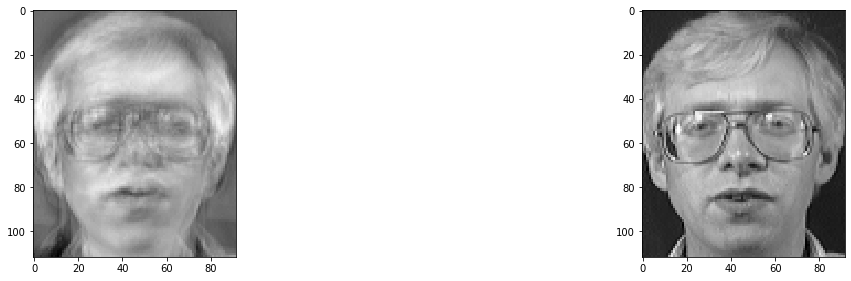

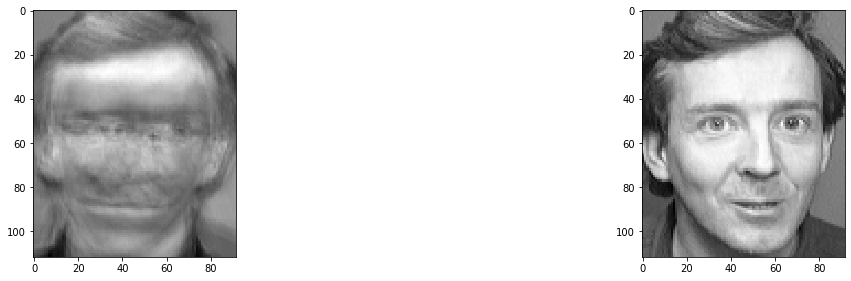

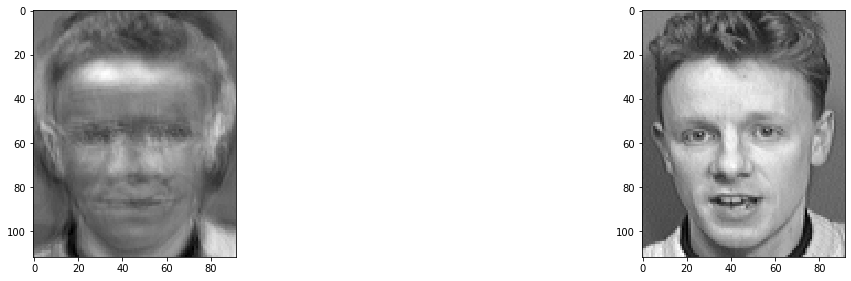

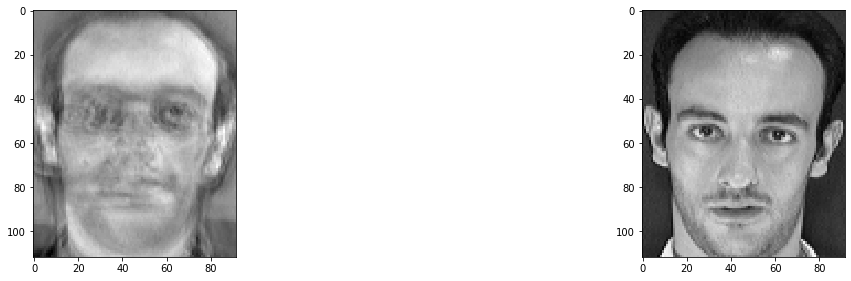

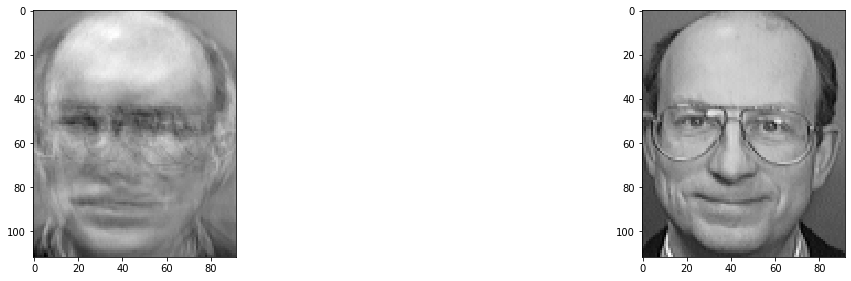

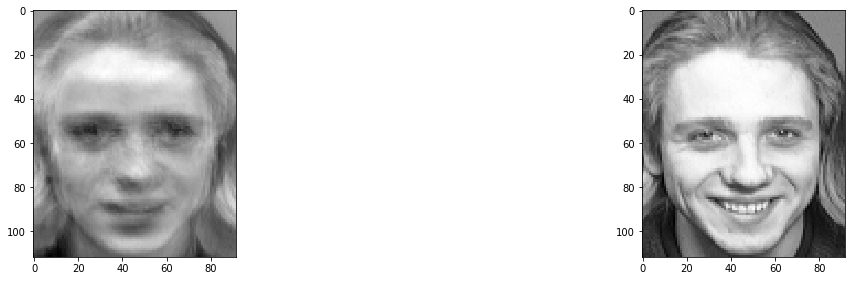

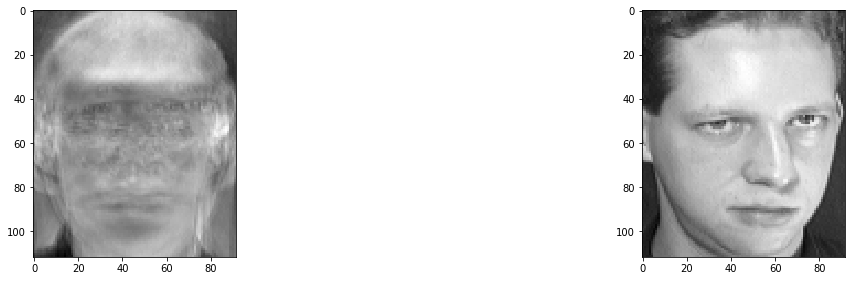

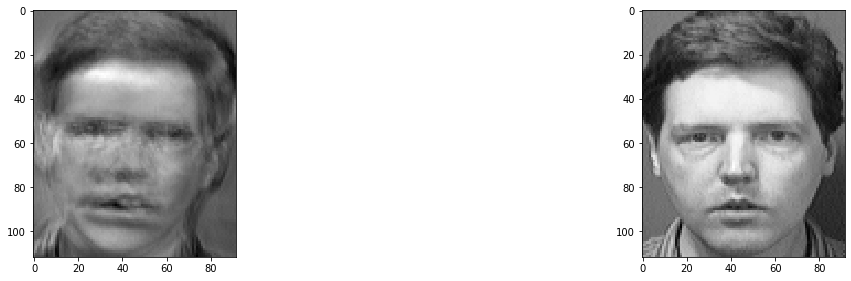

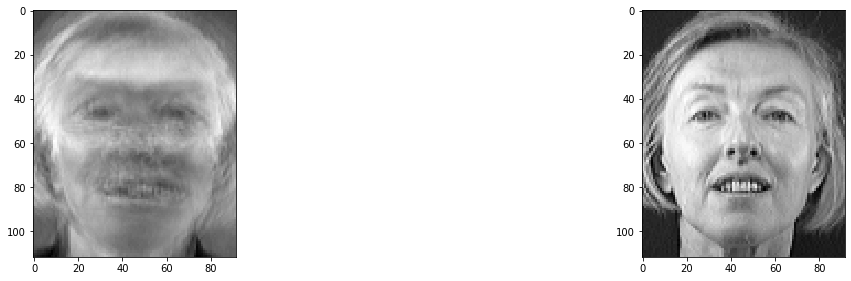

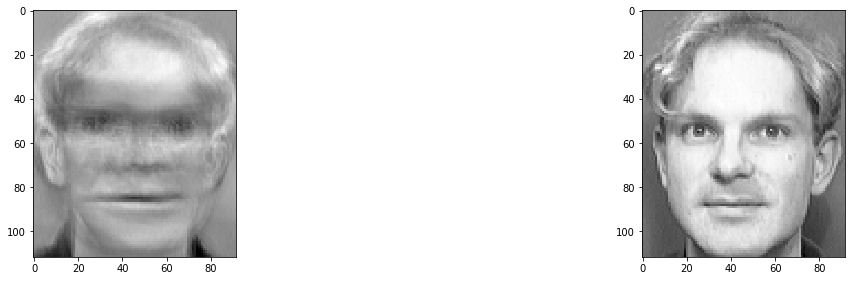

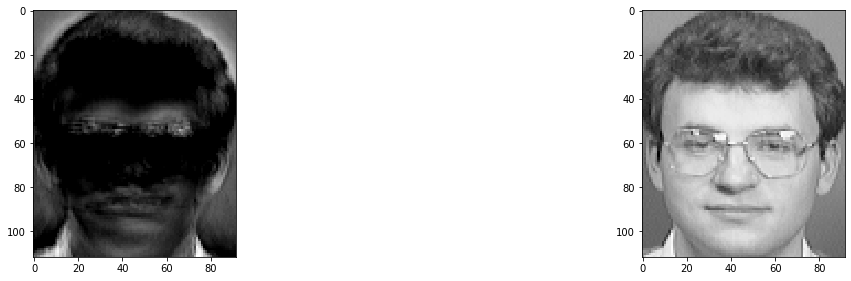

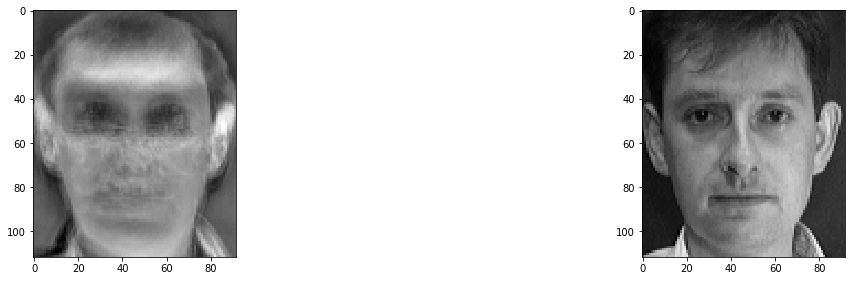

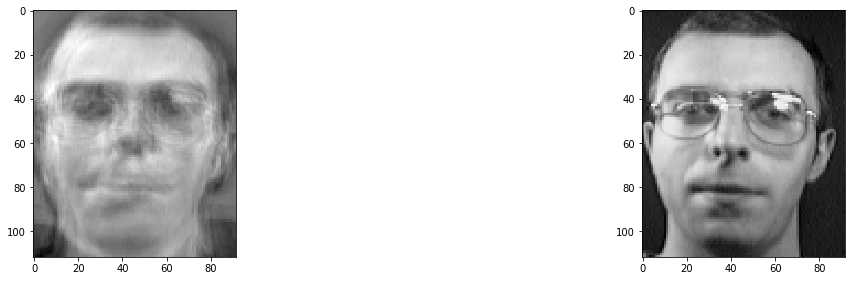

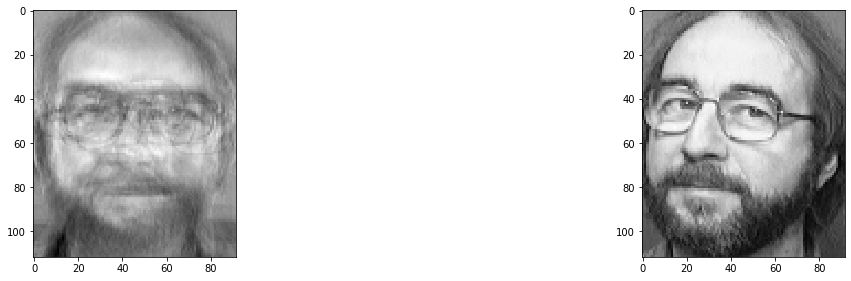

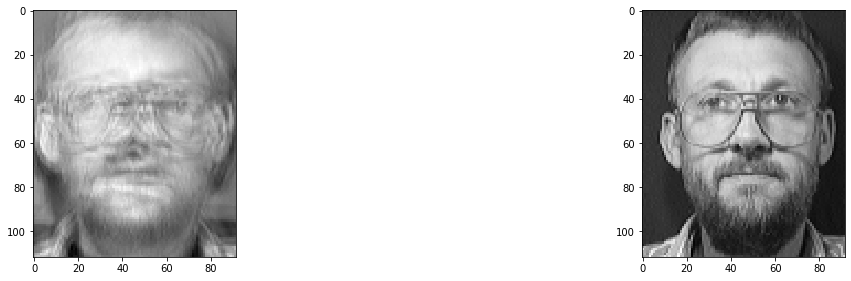

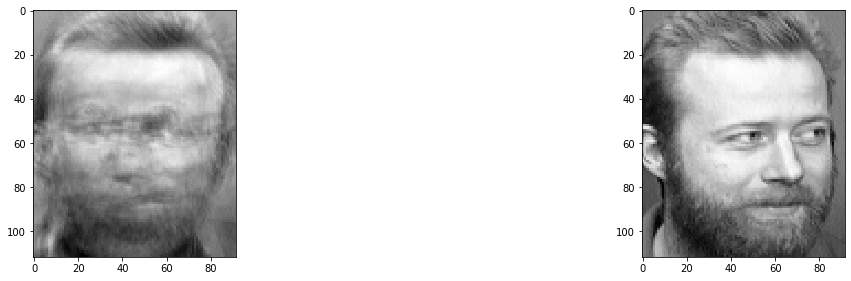

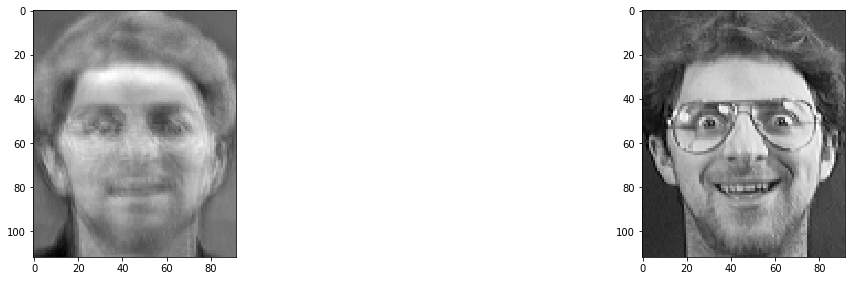

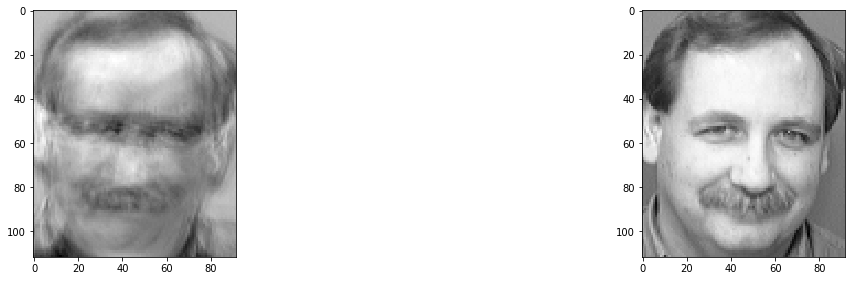

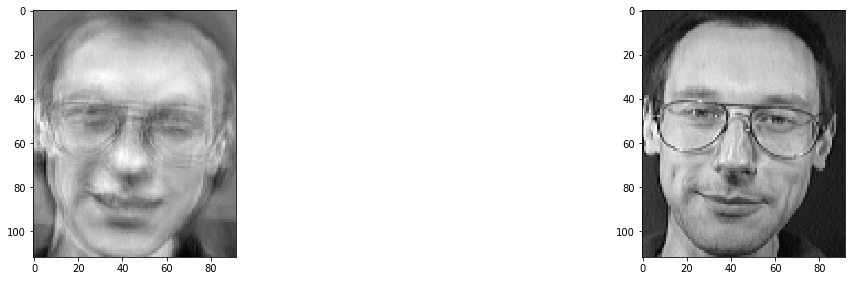

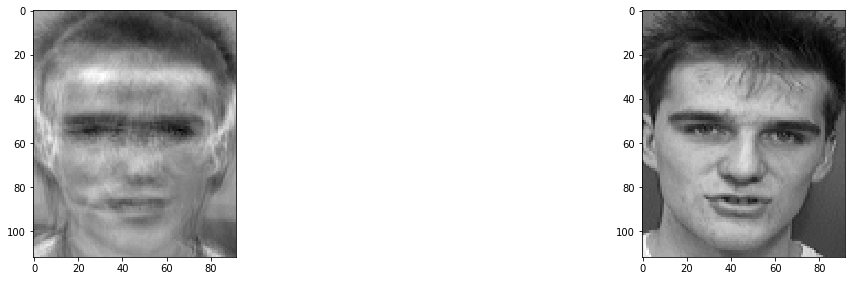

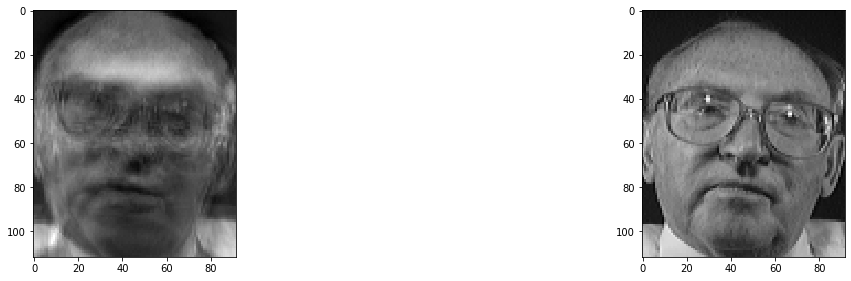

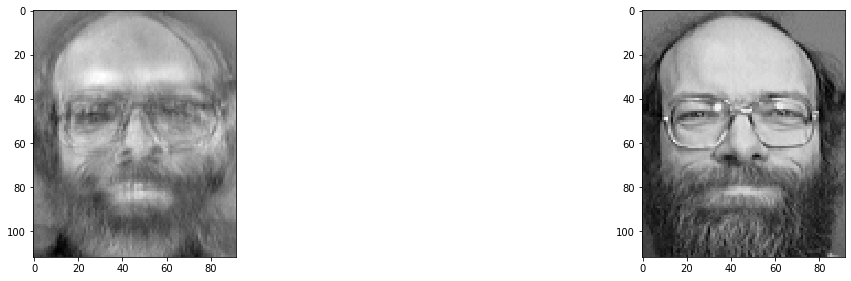

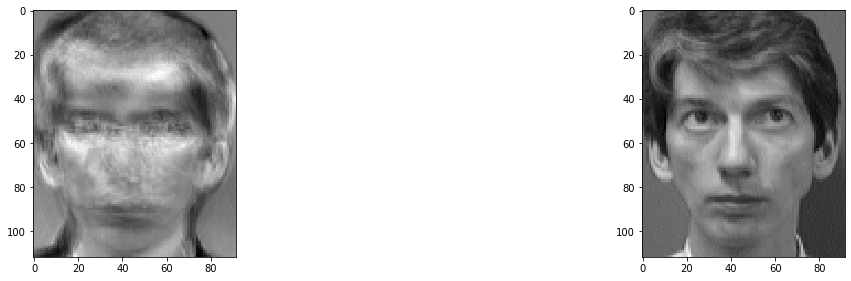

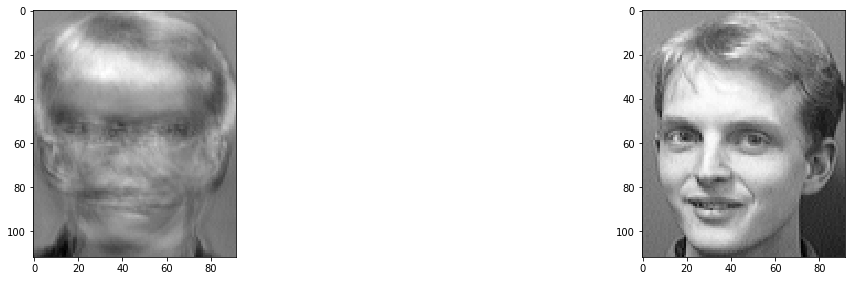

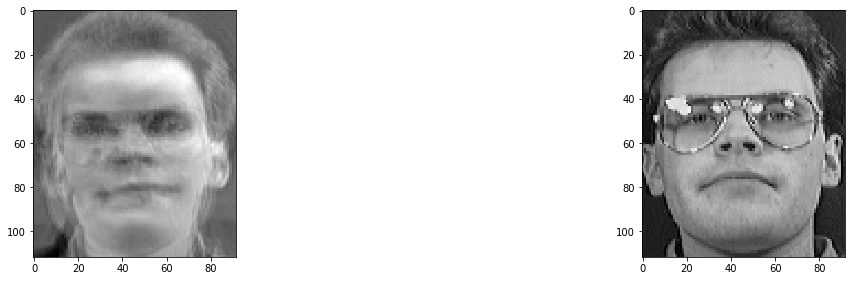

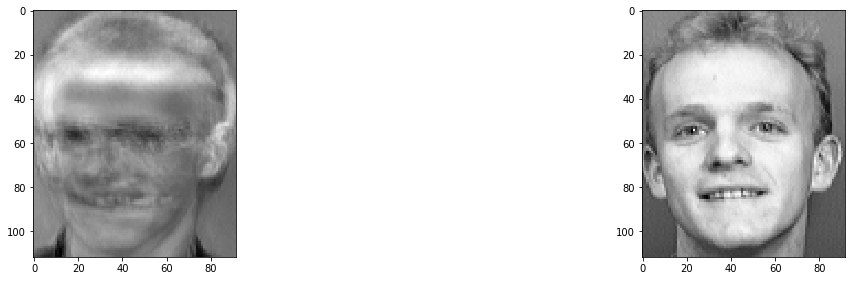

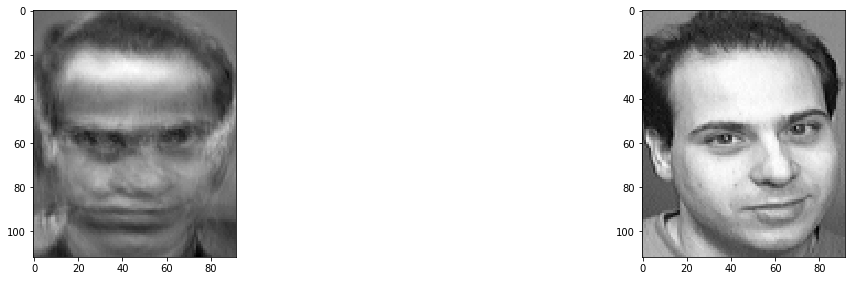

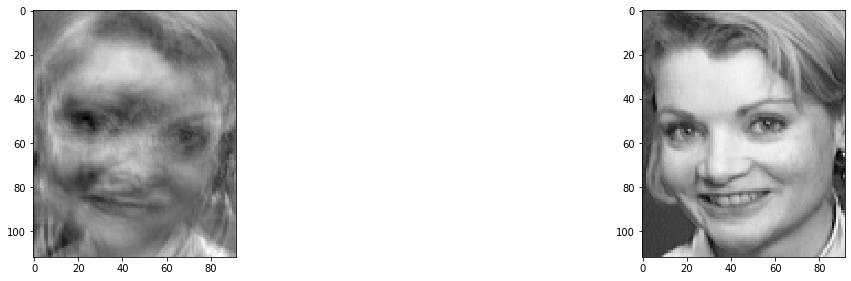

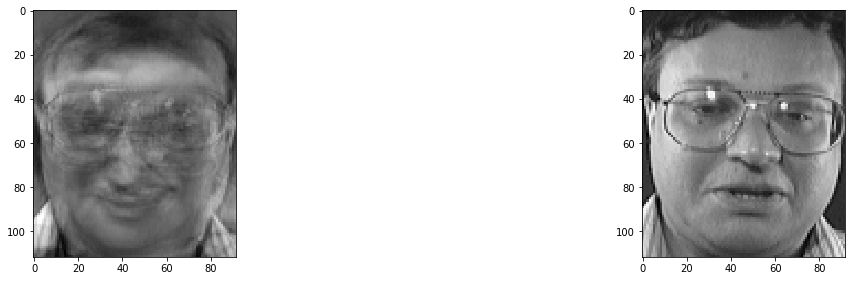

In [ ]:
from scipy.ndimage import gaussian_filter, convolve
pred = ''
def invert(model, img, lr, c, best_loss, best_x, i):
    img = torch.Tensor(img).view(1, -1)
    if not img.requires_grad:
        img.requires_grad = True
        
    optimizer.zero_grad()
    pred = model(img)
    loss = criterion(pred, torch.LongTensor([c]))
    loss.backward()    
    img = torch.clamp(img - lr * img.grad, 0, 255)

    if loss.detach().numpy() < best_loss and i > 10:
        best_loss = loss.detach().numpy()
        best_x = img.detach().numpy()
        

    filt = np.array([
        [0,-1,0],
        [-1,5,-1],
        [0,-1,0]
    ])
    np_a = np.array([np.clip(x + np.random.normal(.5, 1),0,255) for x in img.detach().numpy()])
    i = convolve(np_a.reshape(112, 92), filt)
    
    return best_loss, best_x, np_a.reshape(1, -1)
            
        
for c in classes:
    best_x,best_loss='',float('inf')
    img = np.zeros_like(train_x[0])
    for i in range(100):
        best_loss,best_x,img = invert(model, img, .01, c_to_i(c), best_loss, best_x, i)
    fig = plt.figure(figsize=(20, 10))
    ax1 = fig.add_subplot(2,2,1)
    ax1.imshow(best_x.reshape(112, 92), cmap='gray')
    ax2 = fig.add_subplot(2, 2,2)
    ax2.imshow(test_x[c_to_i(c)].reshape(112, 92), cmap='gray')
    plt.show()
    